Als pip geïnstalleerd is (dit kan bij het installeren van python aangegeven worden), kan de volgende cel geuncommend worden om automatisch alle pakketten die nodig zijn te installeren.

In [40]:
#!pip install numpy scipy matplotlib

De pakketten die nodig zijn worden in de python file geïmporteerd. Hierbij is:

- `numpy` de numerieke wiskunde module voor het gebruik van bijvoorbeeld e-functies en goniometrische functies.
- `scipy` de numerieke solver module voor in dit geval het oplossen van eigenwaarde problemen. `scipy` heeft echter nog meer functies voor bijvoorbeeld het oplossen van differentiaalvergelijkingen en regressiemodules.
- `matplotlib` als plot-module.

`scipy` en `matplotlib` zijn beide grote pakketten, en niet alles is nodig voor dit programma. Daarom worden alleen specifieke gedeeltes van deze modules geïmporteerd.

In [41]:
import numpy as np
from scipy.linalg import eigh_tridiagonal
import matplotlib.pyplot as plt
import matplotlib.animation as PillowWriter
from matplotlib import animation

#plt.style.use("seaborn-v0_8-colorblind") # Sorry ik ben kleurenblind dus ik moet speciale dingen hebben.

# Schroedinger met FDM

Zoals document al aangaf kan de Schroedingervergelijken numeriek opgelost worden door alles in een big ass tri-diagonale matrix te zetten en er een lineaire algebra opdracht van te maken.

$$
\begin{bmatrix}
\frac{1}{\Delta x'^2}+V'_1 & -\frac{1}{2 \Delta x'^2} &   0 & 0...\\
-\frac{1}{2 \Delta x'^2} & \frac{1}{\Delta x'^2}+V'_2 & -\frac{1}{2 \Delta y^2} & 0... \\
...& ... & ... & -\frac{1}{2 \Delta x^2}\\
...0 & 0 & -\frac{1}{2 \Delta x'^2} & \frac{1}{\Delta x'^2}+V'_{N-1}\\
\end{bmatrix} \cdot \begin{pmatrix}
\psi_1\\
\psi_2\\
\vdots\\
\psi_{N-1}
\end{pmatrix} = E' \begin{pmatrix}
\psi_1\\
\psi_2\\
\vdots\\
\psi_{N-1}
\end{pmatrix}
$$


Hier bij zijn: 

- $E' = \frac{m L^2}{\hbar^2} E$
- $V' = \frac{m L^2}{\hbar^2} V$
- $x' = \frac{x}{L}$

dimensieloze grootheden. Dit maakt echter voor het oplossen van $\psi$ niet uit, aangezien deze sowieso dimensieloos is.

Dus volgende dingen zijn nodig in python:

- een functie die het potentiaal definieerd.
- een functie die onze big ass lineaire algebra probleem oplost.

# Functie voor potentiaal

Er wordt een functie gemaakt om het potentiaal te beschrijven. Om een functie te maken in python wordt als eerste het keyword `def` gebruikt om aan te geven dat het om een functie gaat. Vervolgens wordt er een naam aan deze functie gegeven, in dit geval `V_p`. Als laatste wordt tussen haakjes de input variabelen gegeven. Het potentiaal is afhankelijk van de x-as, dus wordt deze variabele `x` genoemd, maar de naam van deze variabele is vrij te kiezen. Vervolgens wordt de regel afgesloten met een dubbele punt.

Dan wordt de `return` gedefinieerd. Dit is wat de functie moet teruggeven wanneer deze gebruikt wordt. Hier wordt alleen een vector teruggegeven die de lengte van `x` heeft met alles een waarde nul. Aangezien voor de FDM-methode er randvoorwaarden gesteld worden voor het oplossen, kan er gewoon een potentiaal van $$V(x) = 0 $$ gedefinieerd worden, en zorgen de randvoorwaarden ervoor dat er een oneindig diepe put ontstaat.

**Let op** dat alles na de dubbele punt met een tab verschoven is. Dit is om aan het programma aan te geven dat dit allemaal binnen de functie valt. Dit is noodzakelijk om te doen, anders werkt het programma niet.


In [42]:
def V_p(x):

    # return np.zeros(len(x)) # Voor infinite square well

    return  100* ((x<=0.25) + (x>=0.75)).astype(float) # Voor finite square well

# Functie voor het lineaire algebra probleem

de tridiagonale matrix bestaat uit:
- 1 hoofddiagonaal
- 2 gelijke nevendiagonalen

`scipy` heeft een functie om eigenwaarde problemen van tridiagonale matrices op te lossen. Dus het stappenplan wordt:

1. definieer de hoofdiagonaal
2. definieer de nevendiagonaal (deze hoeft maar 1 keer gedefinieerd te worden want de de nevendiagonalen moeten altijd gelijk zijn bij een tridiagonale matrix)
3. voer de diagonalen aan de eigenwaarden functie van `scipy` en let de magic happen
    - de `eigenh_tridiagonal` functie van `scipy` geeft de eigenwaarden en eigenvectoren uit in volgorde: eigenwaarden, eigenvectoren
    - het gebruik van deze functie is als volgt :
    
 ```python
 eigenwaarden, eigenvectoren = eigh_tridiagonal(hoofdiagonaal, nevendiagonaal)
 ```
 

**Let op** dat bij het definiëren van de matrix de eerste en laatste entry van de matrix niet meegenomen worden aangezien deze 0 zijn. Daarom is het noodzakelijk om bij het opstellen van de matrix ook deze entries weg te laten in het potentiaal. Vandaar dat er `V_p(x)[1:-1]` staat. De `[1:-1]` geeft aan dat alles waardes in de lijst meegenomen worden, behalve de eerste en laatste.

In [43]:
def Schroedinger(x, dx):

    main = 1/(dx**2) + V_p(x)[1:-1]
    off = -1/(2*dx**2) * np.ones(len(main)-1) # lengte van de nevendiagonalen = lengte van hoofd - 1

    E, psi = eigh_tridiagonal(main, off) # psi word uitgegeven als een matrix waarbij elke kolomn een eigenvector is.

    return E, psi.T # psi wordt dmv psi.T getransponeerd, zodat elke vector 1 rij wordt.
                    # dit hoef je niet te doen maar ik vind het makkelijker met de syntex voor het plotten

# Berekening van eigenvectoren

Nu de functies al geschreven zijn is het makkelijk om de eigenwaarden en eigenvectoren te berekenen. Het enige wat moet gebeuren is dat $x$ en $dx$ gedefinieerd worden (dimensieloos), en dan worden ze aan de functie `Schroedinger` gegegeven.

Vergeet niet dat de randvoorwaarde voor $\psi$

$$\psi(0) = \psi(1) = 0$$

In [44]:
# Variabelen
N = 1000    # aantal gridpoints
dx = 1/N    # spacing van gridpoints
x = np.linspace(0, 1, N+1)

In [45]:
E, psi = Schroedinger(x, dx)

# Controle of $\psi$ genormaliseerd is

er kan getest worden op de normaliteit van $\psi$ door het inproduct te nemen, hierbij geldt

$$\psi_i \cdot \psi_j = \delta_{ij}$$

Het inproduct kan in python berekend worden met de `@` operator.

In [46]:
psi[0]@psi[0] # bijna 1

1.0000000000000013

In [47]:
psi[0]@psi[1] # bijna 0

-7.895721449677351e-17

Nu de functie gerund heeft kunnen we kijken naar de eerste 3 energieniveaus. Pas op dat deze dimensieloos zijn, dus wat er uitgegeven wordt is

$$E'= \frac{mL^2E}{\hbar^2}$$

In [48]:
E[0:5]

array([ 11.93357488,  46.23944218,  96.24968015, 143.4681843 ,
       178.55539665])

Deze zijn dimensieloos, dus om de daadwerkelijke energie te krijgen:

$$ E = \frac{\hbar^2 E'}{m L^2} $$

maar dat doe ik niet want geeft weinig toegevoegde waarde. Je kan ook namelijk dimensieloos plotten.

# plotten van eerste 4 golffuncties

De volgende cellen geef een algoritme voor het plotten van de golffuncties en hun waarschijnlijkheden. Dit kan eenvoudig gedaan worden met een for-loop. In de for-loop zijn volgende dingen aangegeven.

De for-loop begin met het keyword `for` dat aangeeft dat het een for-loop is. Vervolgens wordt de variabele aangegeven waarover geïtereerd dient te worden (hier `i` of `j`. Vervolgens wordt aangegeven over welk bereik geïtereerd wordt. Dit kan een lijst van waardes zijn.

De amplitude van de golffunctie is met 2000 vermenigvuldigd, om de visualisatie beter te maken. Daarom wordt aanbevolen om naar het naar uiteindes te kijken en deze waarde te vergelijken met de hoogte van de put. 

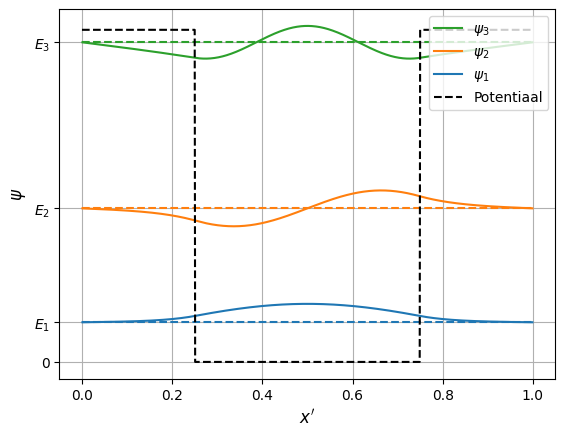

In [49]:
fig, ax = plt.subplots(1,1)
plt.yticks([0, E[0]*2, E[1]*2, E[2]*2] , [r"0", r"$E_1$", r"$E_2$", r"$E_3$"])
ax.grid(True)

plt.gca().set_prop_cycle(None)

#plotting the energy levels
for j in np.linspace(0,2,3):
    plt.plot(x,np.zeros(len(x))+E[int(j)]*2,'--')

plt.gca().set_prop_cycle(None)

for i in range(0,3):
    ax.plot(x[1:-1], psi[i]*200+(E[i]*2), label=("$\psi_{%i}$" %(i+1)))

ax.plot(x, V_p(x)*2, 'k--', label='Potentiaal')

ax.set_xlabel(r"$x'$", fontsize=12)
ax.set_ylabel(r"$\psi$", fontsize=12)

handles, labels = plt.gca().get_legend_handles_labels()
order = [2, 1, 0, 3]

plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order], loc='upper right')

plt.show()

In [50]:
np.max(V_p(x)), E[2]

(100.0, 96.24968014566375)

# Eerste vier waarschijnlijkheden

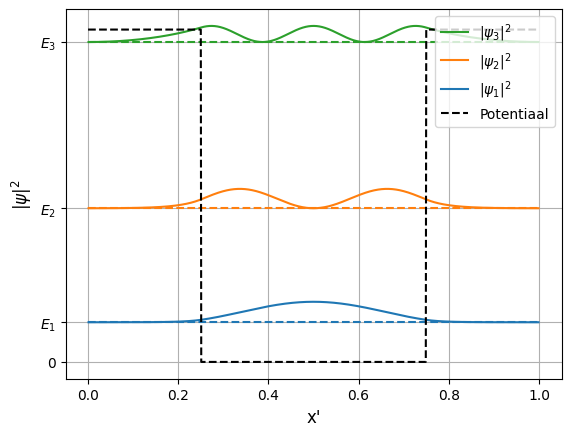

In [51]:
fig, ax = plt.subplots(1,1)
plt.yticks([0, E[0]*2, E[1]*2, E[2]*2] , [r"0", r"$E_1$", r"$E_2$", r"$E_3$"])
ax.grid(True)

plt.gca().set_prop_cycle(None)
#plotting the energy levels
for j in np.linspace(0,2,3):
    plt.plot(x,np.zeros(len(x))+E[int(j)]*2,'--')

plt.gca().set_prop_cycle(None)

for i in range(0,3):
    ax.plot(x[1:-1], np.abs(psi[i])**2*4000+(E[i]*2), label=(r"$\left|\psi_{%i}\right|^2$" %(i+1)))

ax.plot(x, V_p(x)*2, 'k--', label='Potentiaal')
# ax.set_yim([0, 18])
ax.set_xlabel(r"x'", fontsize=12)
ax.set_ylabel(r"$\left| \psi \right|^2$", fontsize=12)

handles, labels = plt.gca().get_legend_handles_labels()
order = [2, 1, 0, 3]

plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order], loc='upper right')
# ax.set_yim([0, 18])
plt.show()

# Energieniveaus plotten

Text(0.5, 0, '$n$')

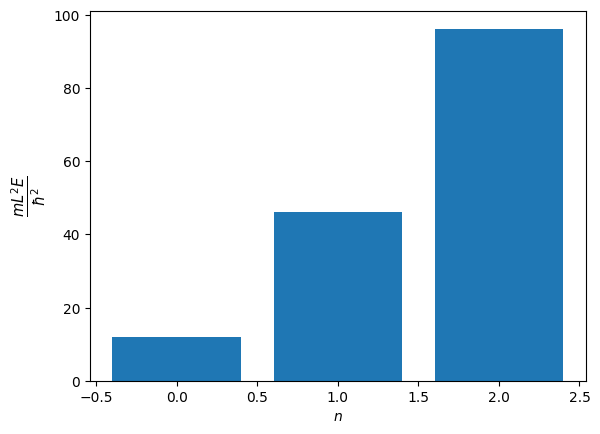

In [52]:
fig, ax = plt.subplots(1,1)

ax.bar(np.arange(0, 3), E[:3])
ax.set_ylabel(r"$\frac{m L^2 E}{\hbar^2}$", fontsize=15)
ax.set_xlabel(r"$n$")

# Validatie

Voor validatie worden de even en oneven energieën bepaald en vergeleken met de theorie doormiddel van de analytische uitkomsten.

even uitkomsten:

$$\sqrt{E} \tan \left( \frac{L \sqrt{2mE}}{2\hbar}\right)$$

oneven uitkomsten:

$$ - \frac{\sqrt{E}}{\tan \left( \frac{L \sqrt{2mE}}{2\hbar}\right)}$$

In [53]:
L = 0.5 # Lengte van de put
V = 100
m = 9.10938356e-31
hbar = 1.05457180013e-34
E_th = np.linspace(0, V, 100)

In [54]:
curve = np.sqrt(V - E_th)
even = np.sqrt(E_th) * np.tan(L*np.sqrt(E_th/2))
oneven = -np.sqrt(E_th)/(np.tan(L*np.sqrt(E_th/2)))
curve2 = np.sqrt(V - E[0:3])

/tmp/ipykernel_17453/23895816.py:3: RuntimeWarning: invalid value encountered in divide
  oneven = -np.sqrt(E_th)/(np.tan(L*np.sqrt(E_th/2)))


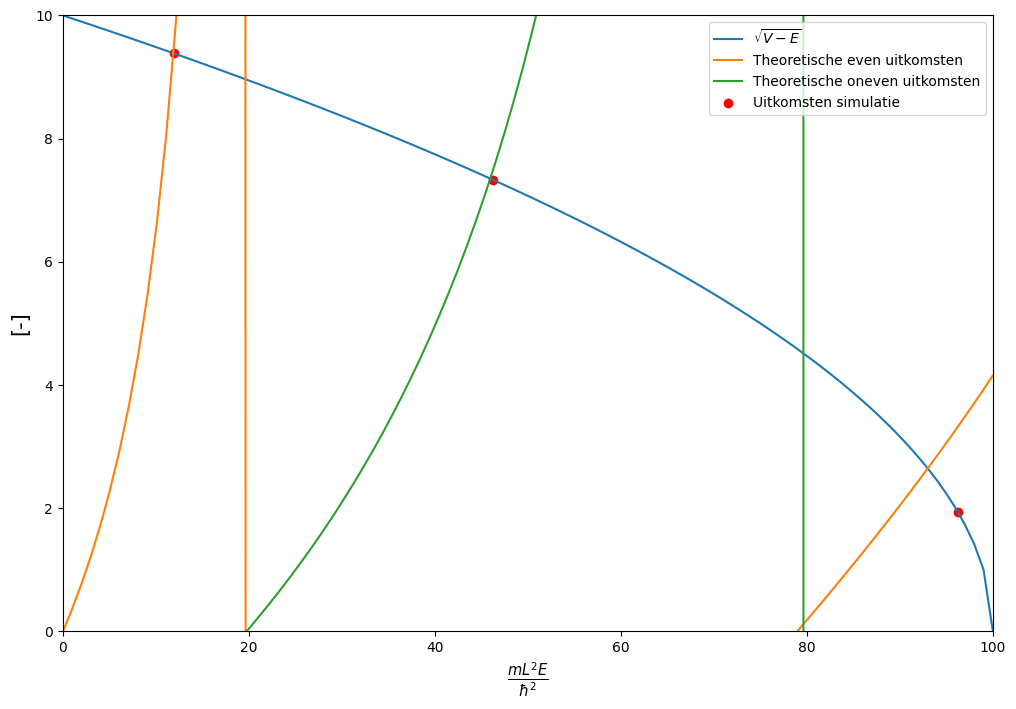

In [55]:
fig, ax = plt.subplots(figsize=(12,8))

ax.plot(E_th, curve, label=r'$\sqrt{V - E}$')
ax.plot(E_th, even, label = 'Theoretische even uitkomsten')
ax.plot(E_th, oneven, label = 'Theoretische oneven uitkomsten')
ax.scatter(E[0:3], curve2, color='red', label = 'Uitkomsten simulatie')
ax.set_ylim([0,np.sqrt(V)])
ax.set_xlim([0, V])

ax.set_xlabel(r'$\frac{mL^2 E}{\hbar^2}$', fontsize=15)
ax.set_ylabel(r'[-]', fontsize=15)

ax.legend(loc='upper right')

plt.show()

# Animatie van tijdsafhankelijke Schrödingervergelijking.

Om de gegenereerde golffuncties tijdsafhankelijk te maken, worden zij vermenigvuldigd met de tijdsafhankelijkheid gegeven door de schrödinger vergelijking. Deze tijdsafhankelijkheid is

$$ e^{-iEt}$$

Deze tijdsafhankelijkheid wordt daarom ook als eerste gedefinieerd.

In [56]:
t = np.linspace(0,2*np.pi/E[0], 120)
index = np.linspace(0,119,120)
time = np.exp(-1j*E[0]*t)


Voor de eindig diepe put zijn niet alle oplossingen die de FDM-methode geeft logisch. Dit komt doordat er gedaan wordt alsof de eindig diepe put in een oneindig diepe put zitten. Analytisch gedraagt een deeltje met een energieniveau dat groter is dan het potentiaal zich als een vrij deeltje. De FDM-methode geeft dan echter een oplossing alsof het deeltje zich in een oneindige diepe bevindt. Om de energieniveaus die groter zijn dan het potentiaal eruit te filteren wordt de indeces gezocht die kleiner zijn. Als eerste worden in `j` alle energieën opgeslagen die kleiner zijn dat het potentiaal. Vervolgens in `ind_j` de indeces opgeslagen van deze indices. Dit is om de gif automatisch aan te passen mocht het potentiaal groter of kleiner gemaakt worden.

In [57]:
# find energies smaller than V(x)

j = [i for i in E if i < np.max(V_p(x))]

# find indeces for energies smaller than V(x)
ind_j = [E.tolist().index(j[i]) for i in range(len(j))]

Vervolgens wordt er een animatie uitgevoerd. De animatie wordt stap voor stap doorgelopen.

Als eerste wordt er een figuur gemaakt met `plt.figure()` dit zorgt gewoon voor een wit vierkant blad met niks erop. Vervolgens wordt een `N` gedefinieerd. Dit is het aantal golffuncties dat geplot moet worden. In dit geval wordt hier de lengte van `j` aangegeven. Dit is de lengte van de lijst van energieën die kleiner zijn dan het potentiaal, berekend in de vorige cel. Daarna worden specifieke zaken gedefinieerd voor de plot. Zo word er een assenstelsel gemaakt met `plt.axes` met daarin het bereik van de x- en y-as. De assen-labels worden gedefinieerd met `plt.xlabel` en `plt.ylabel`, en de domeinen van de y-as worden gedefinieerd met `plt.yticks`. De ticks zijn eigenlijk de intervallen over de y-as.

Vervolgens wordt in een variabele `lines` de plot gedefinieerd. Hierin wordt aangegeven welke lijnen er in een plot komen, echter zijn deze lijnen nog leeg aangezien de functie nog niet gekoppeld is aan deze lijnen. Er worden daarom dus 4 lege lijnen gemaakt, één voor iedere golffunctie. Vervolgens wordt met de variabele `patches` aangegeven wat geupdate moet worden over de tijd.

Nadien wordt het potentiaal geplot. Dit kan buiten de animatie gebeuren aangezien het potentiaal niet afhaneklijk is van de tijd. Dit is dus gewoon een statische plot.

`plt.gca().set_prop_cycle(None)` geeft aan dat voor elke loop dezelfde kleuren cyclus gebruikt wordt. Dit zorgt ervoor dat de energie niveaus en bijbehorende golffuncties dezelfde kleur krijgen.

Daarna wordt een functie voor de animatie gecreeerd. Eigenlijk werkt deze functie als een for-loop die elke iteratie de nieuwe curve berekend en updated in de variabele `patches`. In deze for-loop wordt eerste de tijdsafhankelijkheid berekend. Daarna wordt de tijdsafhankelijkheid aan de golffunctie toegevoegd, waarna deze golffunctie aan een lijn wordt gekoppeld. Hierin wordt geïtereerd over zowel de lijnen als ook de golffuncties.

Daarna worden de labels en bijbehorende functies opgeslagen in de variabelen `handles` en `patches`. Aangezien de volgorde in de legende veranderd wordt (eerst de golffuncties van hoog naar laag en dan het potentiaal) moet deze volgorde aangegeven worden in in lijst. Deze lijst wordt opgeslagen in de variabele `order`. Daarna wordt met `plt.legenend()` de legenda weergegeven in de grafiek.

Dan wordt de functie geanimeerd met `animation.FuncAnimation()`. In deze functie wordt als eerste de naam van het figuur dat geanimeerd moet worden aangegeven, in dit geval de variabele `fig`. Vervolgens moet de functie aangegeven worden die voor de animatie zorgt, namelijk de functie `animate`. Daarna moet aangegeven uit hoeveel frames de animatie bestaat. Het aantal frames is de lengte van de lijst met tijden gedefinieerd in de vorige cel. Daarna wordt het interval aangegeven, wat de vertraging is tussen opeenvolgende frames in ms. Er zit dus 50 ms tussen de frames. Vervolgens wordt een attribute `blit` gelijk gezet aan `True` dit geeft aan dat elke iteratie alleen de dingen geplot moeten worden die ook daadwerkelijk veranderen. Dit verkort de computatie tijd. Dit alles wordt opgeslagen in een variabele `anim`.

Vervolgens kan de animatie worden opgeslagen als .gif bestand met de `anim.save()` functie. In deze functie kan aangegeven worden uit hoeveel fps de gif moet bestaan. Hierin kan natuurlijk gevarieerd worden waneer dit nodig is. Hoe hoger de fps wordt, hoe langzamer de gif.



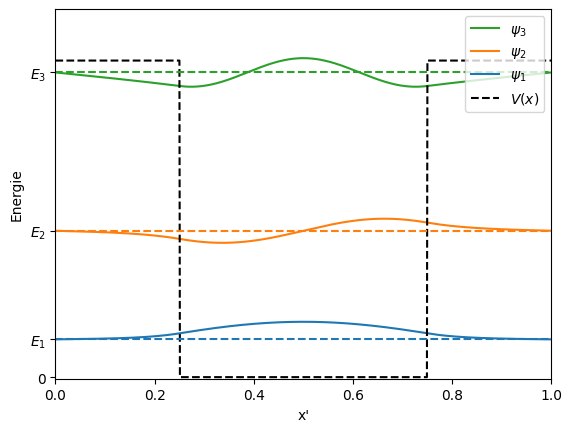

In [58]:
fig = plt.figure()
N = len(j)
ticks = [i for i in j]
ticks.insert(0, 0)
label = [(r"$E_%i$" % (j.index(i)+1)) for i in j]
label.insert(0, r"0")

#defining how the plot will look
plt.axes(xlim=(0, 1), ylim=(0-0.5, E[N-1]+20))
plt.xlabel("x'")
plt.ylabel('Energie')
plt.yticks(ticks, label)

#defining the mumber of wavefunctions shown
lines = [plt.plot([], [], label=(r"$\psi_{%i}$" % (_+1)))[0] for _ in range(N)] #lines to animate

patches = lines #things to animate

#plotting the defined potential in black dotted line
pot=plt.plot(x, V_p(x), 'k--', label=r'$V(x)$')

plt.gca().set_prop_cycle(None)
#plotting the energy levels
for l in np.linspace(0,N-1,N):
    plt.plot(x,np.zeros(len(x))+E[int(l)],'--')

def animate(i):
    #animate lines
    for k,line in enumerate(lines):
        time = np.exp(-1j*E[k]*t)
        psi_t = psi[k]*time[i]
        line.set_data(x[1:-1], np.real(psi_t*100)+E[k])
        
    return patches #return everything that must be updated

handles, labels = plt.gca().get_legend_handles_labels()
order = [j.index(i) for i in j]
order.reverse()
order.append(len(j))
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order], loc='upper right')

anim = animation.FuncAnimation(fig, animate,
                                frames=len(t), interval=50, blit=True)

anim.save('finite.gif', fps=30, dpi=100)

Het proces vooraf beschreven wordt nogmaals doorlopen voor de volgende animatie, alleen voor een subplot. Echter blijft het principe hiervoor precies hetzelfde.

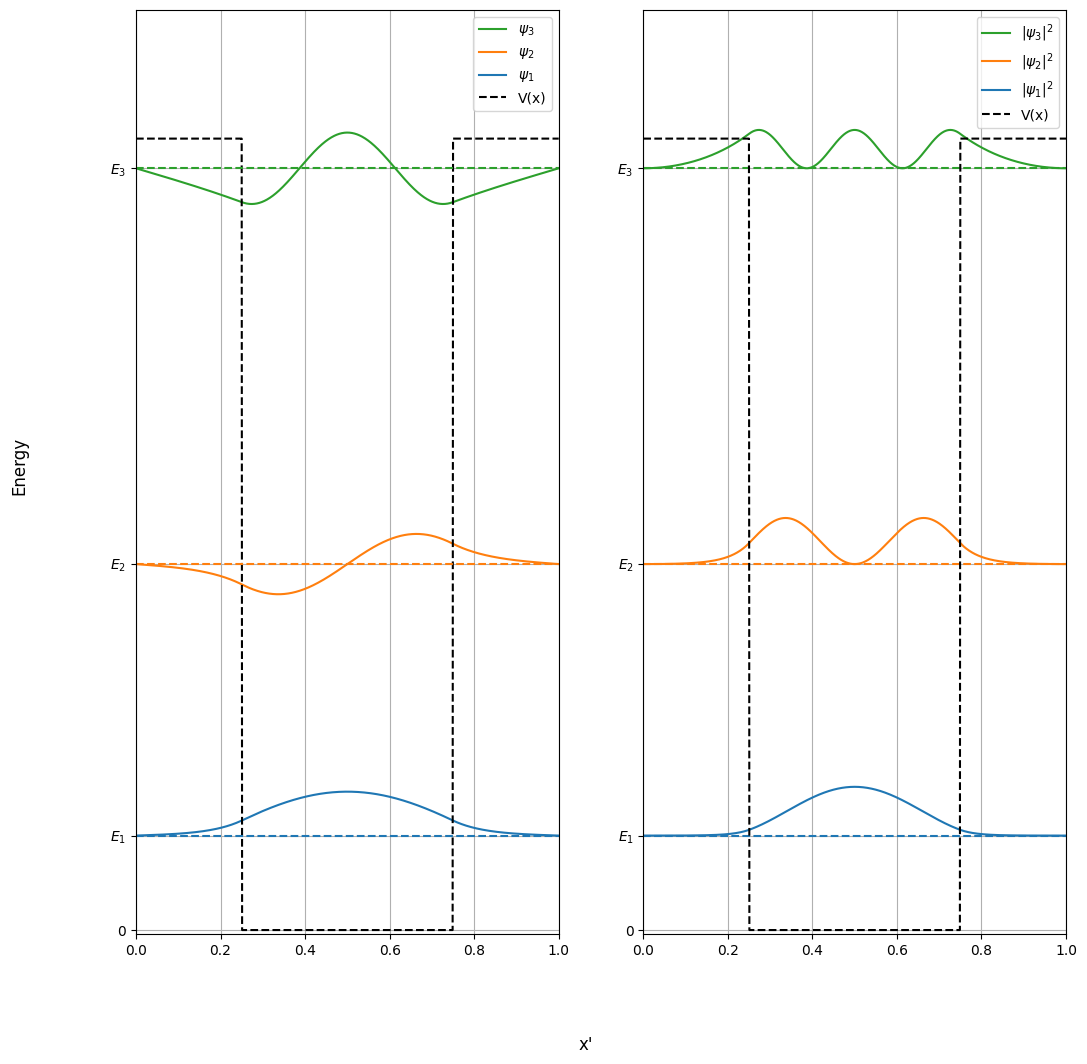

In [59]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,12))

#defining how the animted plot will look

fig.supxlabel("x'")
fig.supylabel('Energy')
ax1.grid(True)
ax2.grid(True)

ax1.set_yticks(ticks, label)
ax2.set_yticks(ticks, label)
ax1.set(xlim=(0, 1), ylim=(-0.5, E[N-1]+20))
ax2.set(xlim=(0, 1), ylim=(-0.5, E[N-1]+20))

#defining the mumber of wavefunctions shown
N = len(j)
lines = [ax1.plot([], [], label=(r"$\psi_{%i}$" % (_+1)))[0] for _ in range(N)] #lines to animate
patches = lines #things to animate

ax1.set_prop_cycle(None)


#plotting the defined potential in black dotted line
pot=ax1.plot(x, V_p(x), 'k--', label="V(x)")

#plotting the energy levels #AX1
for i in np.linspace(0,N-1,N):
    ax1.plot(x,np.zeros(len(x))+E[int(i)],'--')

# legend
handles, labels = ax1.get_legend_handles_labels()
order = [j.index(i) for i in j]
order.reverse()
order.append(len(j))
ax1.legend([handles[ind] for ind in order], [labels[ind] for ind in order], loc='upper right')

# def init():
#     #init linesb
#     for line in lines:
#         line.set_data([], [])

    # return patches #return everything that must be updated

def animate(i):
    #animate lines
    for k,line in enumerate(lines):
        time = np.exp(-1j*E[k]*t)
        psi_t = psi[k]*time[i]
        line.set_data(x[1:-1], np.real(psi_t)*100+E[k])
        
    return patches #return everything that must be updated


#plotting the psi^2 next to the animation

#AX2
for i in range(0,N):
    ax2.plot(x[1:-1], np.abs(psi[i])**2*2000+(E[i]), label=(r"$\left|\psi_{%i}\right|^2$" %(i+1)))

ax2.set_prop_cycle(None)

for i in np.linspace(0,N-1,N):
    ax2.plot(x,np.zeros(len(x))+E[int(i)],'--')

ax2.plot(x, V_p(x), 'k--', label="V(x)")

# legend

handles, labels = ax2.get_legend_handles_labels()
ax2.legend([handles[ind] for ind in order], [labels[ind] for ind in order], loc = 'upper right')

anim = animation.FuncAnimation(fig, animate,
                               frames=len(t), interval=50, blit=True)

anim.save('finite_prop.gif', fps=30, dpi=100)